In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# path to algorithm output data
ind_time_filepath = "../output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"
# path to raw SAPCR data
raw_data = "../PROM-RulesBasedAlgorithmData_R2.0.xlsx"

In [3]:
domain_code_to_name = {"ui_domain" : "Urinary Incontinence Domain",
                      "sf_domain" : "Sexual Function Domain",
                       "uio_domain" : "Urinary Obstruction Domain",
                       "bf_domain" : "Bowel Function Domain",
                       "hf_domain" : "Hormonal Function Domain",
                       "q6d" : "Blood Stools Question"
                      }

In [6]:
ind_time_df = pd.read_csv(ind_time_filepath)
raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(ind_time_df))
print(ind_time_df.head())
print(len(raw_data_df))
print(raw_data_df.head())

16319
  Patient Identifier           Time Point Urinary Incontinence Domain State  \
0  15970_370765.json  2019-04-09 00:00:00                            Normal   
1  15970_413565.json  2020-12-05 00:00:00                          Abnormal   
2   9204_198609.json  2015-05-12 00:00:00                            Normal   
3   9204_235725.json  2015-11-04 00:00:00                            Normal   
4   9204_279366.json  2016-08-29 22:25:00                            Normal   

  Urinary Irritation/Obstruction Domain State Bowel Function Domain State  \
0                     Clinically Urgent Alert                      Normal   
1                     Clinically Urgent Alert                      Normal   
2                                      Normal                      Normal   
3                                      Normal                    Abnormal   
4                     Clinically Urgent Alert                      Normal   

  Q6d State Sexual Function Domain State Hormonal Functi

# Alert Types

In [7]:
# Average interval
data = raw_data_df.groupby('CapstudiesID')['Interval'].apply(list)
avg_interval = 0
interval_count = 0
for id in data.keys():
    intervals = data[id]
    intervals.sort()
    interval_diff = [t - s for s, t in zip(intervals, intervals[1:])]
    interval_count += len(interval_diff)
    avg_interval += sum(interval_diff)

print(f"The average interval between reports is {int(avg_interval/interval_count)}")

The average interval between reports is 11


In [8]:
# Average last report
data = raw_data_df.groupby('CapstudiesID')['Interval'].apply(list)
avg_interval = 0
interval_count = 0
for id in data.keys():
    intervals = data[id]
    intervals.sort()
    interval_count += 1
    avg_interval += intervals[-1]

print(f"The last report is on average {int(avg_interval/interval_count)} months after the first report")

The last report is on average 27 months after the first report


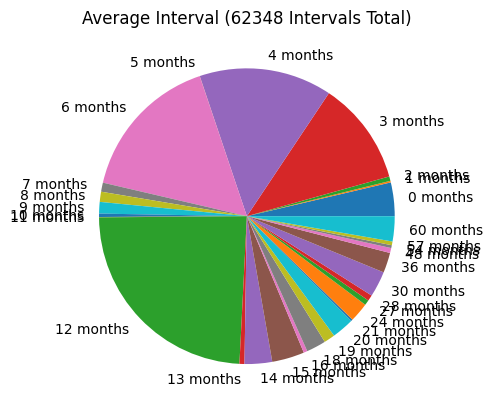

In [9]:
# How many participants have an interval of 3
data = raw_data_df.groupby('CapstudiesID')['Interval'].apply(list)
avg_interval = []
for id in data.keys():
    intervals = data[id]
    intervals.sort()
    interval_diff = [t - s for s, t in zip(intervals, intervals[1:])]
    avg_interval.append(int(sum(interval_diff)/len(interval_diff)))

# print(f"The average interval: {[(interval, avg_interval.count(interval)) for interval in set(avg_interval)]}")

plt.pie([avg_interval.count(interval) for interval in set(avg_interval)], labels = [f"{interval} months" for interval in set(avg_interval)])
plt.title(f"Average Interval ({sum(avg_interval)} Intervals Total)")
plt.show()

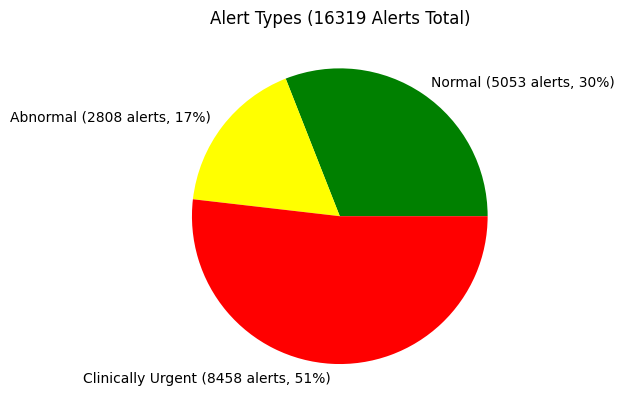

In [11]:
# Look at the frequency for the different types of alerts (normal, abnormal, clinically urgent)

alert_types = [ind_time_df['Final Alert State'].value_counts()['Normal'], ind_time_df['Final Alert State'].value_counts()['Abnormal'], ind_time_df['Final Alert State'].value_counts()['Clinically Urgent Alert']]
plt.pie(alert_types, labels = [f"Normal ({alert_types[0]} alerts, {int(100*alert_types[0]/sum(alert_types))}%)",
                               f"Abnormal ({alert_types[1]} alerts, {int(100*alert_types[1]/sum(alert_types))}%)",
                               f"Clinically Urgent ({alert_types[2]} alerts, {int(100*alert_types[2]/sum(alert_types))}%)"], colors=["green","yellow","red"])
plt.title(f"Alert Types ({sum(alert_types)} Alerts Total)")
plt.show()

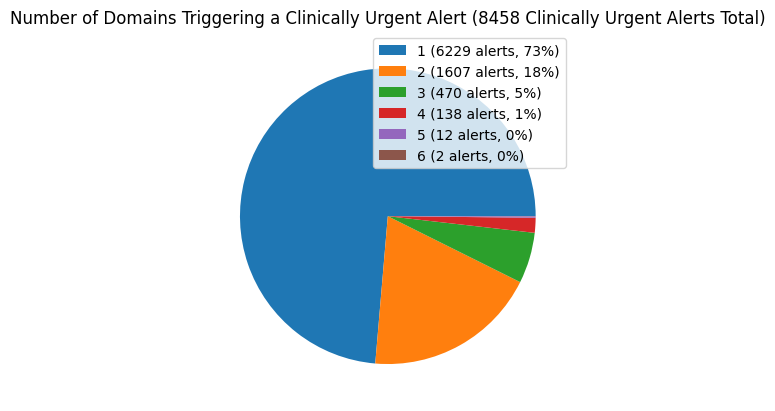

In [12]:
# Number of domains triggering a clinically urgent alert
no_triggering_domains = ind_time_df.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

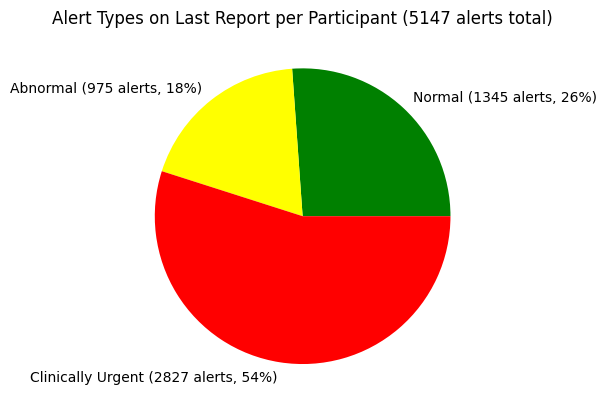

In [13]:
# Look at the frequency of different types of alerts for each subject's last report

data = ind_time_df.groupby('Patient Identifier')['Final Alert State'].apply(list)
alert_types_later = {}
for id in data.keys():
    patient_id = id.split('_')[0]
    if patient_id not in alert_types_later:
        alert_types_later[patient_id] = data[id]
    else:
        alert_types_later[patient_id] += data[id]
        
alert_types_later_vals = [l[-1] for l in list(alert_types_later.values())]
alert_types_later_vals = [alert_types_later_vals.count("Normal"), alert_types_later_vals.count("Abnormal"), alert_types_later_vals.count("Clinically Urgent Alert")]
plt.pie(alert_types_later_vals, labels = [f"Normal ({alert_types_later_vals[0]} alerts, {int(100*alert_types_later_vals[0]/sum(alert_types_later_vals))}%)",
                                          f"Abnormal ({alert_types_later_vals[1]} alerts, {int(100*alert_types_later_vals[1]/sum(alert_types_later_vals))}%)",
                                          f"Clinically Urgent ({alert_types_later_vals[2]} alerts, {int(100*alert_types_later_vals[2]/sum(alert_types_later_vals))}%)"], colors=["green","yellow","red"])
plt.title(f"Alert Types on Last Report per Participant ({sum(alert_types_later_vals)} alerts total)")
plt.show()

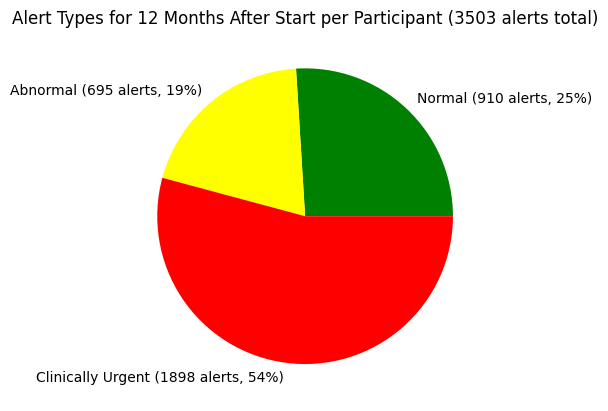

In [14]:
# Look at the frequency of different types of alerts for 12 months after start

interval_data = raw_data_df.groupby('CapstudiesID')['Interval'].apply(list)
id_data = raw_data_df.groupby('CapstudiesID')['PROAnswerSetID'].apply(list)
ids = []
for id in interval_data.keys():
    for i in range(len(interval_data[id])):
        if interval_data[id][i] == 12:
            ids.append(f"{id}_{id_data[id][i]}.json")

data = ind_time_df.groupby('Patient Identifier')['Final Alert State'].apply(list)
alert_types_later_vals = []
for id in data.keys():
    if id in ids:
       alert_types_later_vals.append(data[id][0])

alert_types_later_vals = [alert_types_later_vals.count("Normal"), alert_types_later_vals.count("Abnormal"), alert_types_later_vals.count("Clinically Urgent Alert")]
plt.pie(alert_types_later_vals, labels = [f"Normal ({alert_types_later_vals[0]} alerts, {int(100*alert_types_later_vals[0]/sum(alert_types_later_vals))}%)",
                                          f"Abnormal ({alert_types_later_vals[1]} alerts, {int(100*alert_types_later_vals[1]/sum(alert_types_later_vals))}%)",
                                          f"Clinically Urgent ({alert_types_later_vals[2]} alerts, {int(100*alert_types_later_vals[2]/sum(alert_types_later_vals))}%)"], colors=["green","yellow","red"])
plt.title(f"Alert Types for 12 Months After Start per Participant ({sum(alert_types_later_vals)} alerts total)")
plt.show()

# Alerts over Time

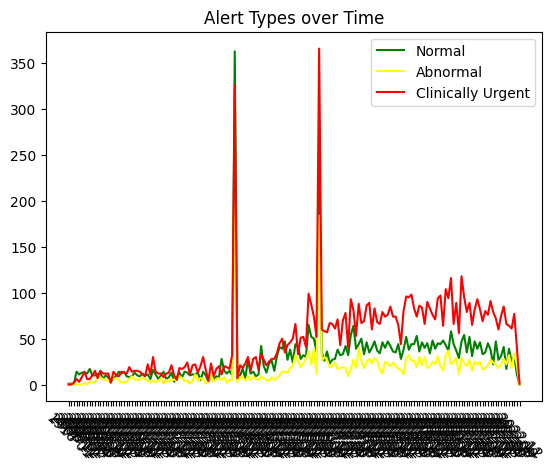

In [15]:
# Look at the frequency of different types of alerts over time on a monthly basis

month_start = -1
month_end = 100

# # spike 1
# month_start = 50
# month_end = 75

# # spike 2
# month_start = 90
# month_end = 115

alert_types = list(ind_time_df['Final Alert State'])
alert_times = list(ind_time_df['Time Point'])
alert_types_and_time = [[alert_times[i], alert_types[i]] for i in range(len(alert_times))]

alert_types_by_month = {}
for alert in alert_types_and_time:
    month = '-'.join(alert[0].split('-')[:2])
    if month not in alert_types_by_month:
        alert_types_by_month[month] = [alert[1]]
    else:
        alert_types_by_month[month].append(alert[1])
        
monthly_normals = []
monthly_abnormals = []
monthly_urgents = []
for month in alert_types_by_month.keys():
    monthly_normals.append([month, alert_types_by_month[month].count("Normal")])
    monthly_abnormals.append([month, alert_types_by_month[month].count("Abnormal")])
    monthly_urgents.append([month, alert_types_by_month[month].count("Clinically Urgent Alert")])
    
monthly_normals.sort(key=lambda pair: pair[0])
monthly_abnormals.sort(key=lambda pair: pair[0])
monthly_urgents.sort(key=lambda pair: pair[0])

if month_start >= 0:
    monthly_normals = monthly_normals[month_start:month_end]
    monthly_abnormals = monthly_abnormals[month_start:month_end]
    monthly_urgents = monthly_urgents[month_start:month_end]

plt.plot([x[0] for x in monthly_normals], [x[1] for x in monthly_normals], color="green")
plt.plot([x[0] for x in monthly_abnormals], [x[1] for x in monthly_abnormals], color="yellow")
plt.plot([x[0] for x in monthly_urgents], [x[1] for x in monthly_urgents], color="red")
plt.xticks(rotation = -45) # Rotates X-Axis Ticks by 45-degrees
plt.legend(['Normal', 'Abnormal', 'Clinically Urgent'])
plt.title("Alert Types over Time")
plt.show()

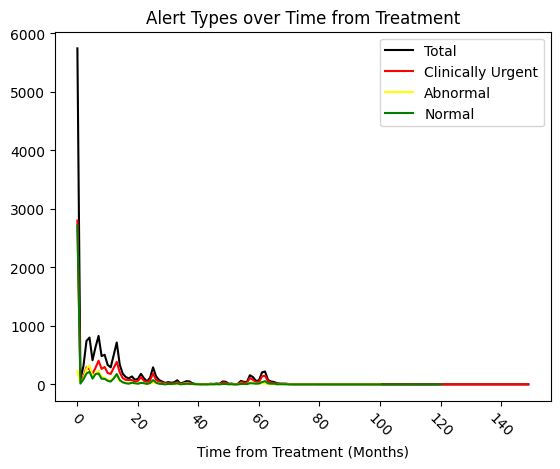

In [20]:
skipped_patient_ids = ['14455'] # ignore these ids, data isn't clean enough
alert_types = list(ind_time_df['Final Alert State'])
alert_times = list(ind_time_df['Time Point'])
patient_ids = list(ind_time_df['Patient Identifier'])
alerts_by_patient = {}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    if patient_id in skipped_patient_ids:
        continue
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
urgent_alert_times = []
abnormal_alert_times = []
normal_alert_times = []
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    sorted_alerts = alerts_by_patient[patient_id]
    
    urgent_alert_times += [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Clinically Urgent Alert']
    abnormal_alert_times += [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Abnormal']
    normal_alert_times += [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Normal']
    alerts_by_patient[patient_id] = {"Urgent": [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Clinically Urgent Alert'],
                                     "Abnormal": [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Abnormal'],
                                     "Normal": [int((alert[0] - sorted_alerts[0][0]).days / 30) for alert in sorted_alerts if alert[1] == 'Normal']}

total_alert_times = [(time, normal_alert_times.count(time) + abnormal_alert_times.count(time) + urgent_alert_times.count(time)) for time in set(normal_alert_times + abnormal_alert_times + urgent_alert_times)]
urgent_alert_times = [(time, urgent_alert_times.count(time)) for time in set(urgent_alert_times)]
abnormal_alert_times = [(time, abnormal_alert_times.count(time)) for time in set(abnormal_alert_times)]
normal_alert_times = [(time, normal_alert_times.count(time)) for time in set(normal_alert_times)]

plt.plot([x[0] for x in total_alert_times], [x[1] for x in total_alert_times], color="black")
plt.plot([x[0] for x in urgent_alert_times], [x[1] for x in urgent_alert_times], color="red")
plt.plot([x[0] for x in abnormal_alert_times], [x[1] for x in abnormal_alert_times], color="yellow")
plt.plot([x[0] for x in normal_alert_times], [x[1] for x in normal_alert_times], color="green")
plt.xticks(rotation = -45) # Rotates X-Axis Ticks by 45-degrees
plt.legend(['Total', 'Clinically Urgent', 'Abnormal', 'Normal'])
plt.title(f"Alert Types over Time from Treatment")
plt.xlabel("Time from Treatment (Months)")
plt.show()


In [ ]:
# Alerts by report number
skipped_patient_ids = ['14455'] # ignore these ids, data isn't clean enough
alert_types = list(ind_time_df['Final Alert State'])
alert_times = list(ind_time_df['Time Point'])
patient_ids = list(ind_time_df['Patient Identifier'])
alerts_by_patient = {}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    if patient_id in skipped_patient_ids:
        continue
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
urgent_alert_times = []
abnormal_alert_times = []
normal_alert_times = []
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    
    urgent_alert_times += [alert[0] for alert in sorted_alerts if alert[1] == 'Clinically Urgent Alert']
    abnormal_alert_times += [alert[0] for alert in sorted_alerts if alert[1] == 'Abnormal']
    normal_alert_times += [alert[0] for alert in sorted_alerts if alert[1] == 'Normal']
    alerts_by_patient[patient_id] = {"Urgent": [alert[0] for alert in sorted_alerts if alert[1] == 'Clinically Urgent Alert'],
                                     "Abnormal": [alert[0] for alert in sorted_alerts if alert[1] == 'Abnormal'],
                                     "Normal": [alert[0] for alert in sorted_alerts if alert[1] == 'Normal']}

total_alert_times = [(time, normal_alert_times.count(time) + abnormal_alert_times.count(time) + urgent_alert_times.count(time)) for time in set(normal_alert_times + abnormal_alert_times + urgent_alert_times)]
urgent_alert_times = [(time, urgent_alert_times.count(time)) for time in set(urgent_alert_times)]
abnormal_alert_times = [(time, abnormal_alert_times.count(time)) for time in set(abnormal_alert_times)]
normal_alert_times = [(time, normal_alert_times.count(time)) for time in set(normal_alert_times)]

plt.plot([x[0] for x in total_alert_times], [x[1] for x in total_alert_times], color="black")
plt.plot([x[0] for x in urgent_alert_times], [x[1] for x in urgent_alert_times], color="red")
plt.plot([x[0] for x in abnormal_alert_times], [x[1] for x in abnormal_alert_times], color="yellow")
plt.plot([x[0] for x in normal_alert_times], [x[1] for x in normal_alert_times], color="green")
plt.xticks(rotation = -45) # Rotates X-Axis Ticks by 45-degrees
plt.legend(['Total', 'Clinically Urgent', 'Abnormal', 'Normal'])
plt.title(f"{subgroup} Alert Types over Report Number")
plt.xlabel("Report Number")
plt.show()


# Alerting Domains

In [ ]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()

In [ ]:
# Look at the frequency of which domains trigger a clinically urgent alert for each subject's last report

alert_data = ind_time_df.groupby('Patient Identifier')['Final Alert State'].apply(list)
domain_data = ind_time_df.groupby('Patient Identifier')['Alerting Domains'].apply(list)
alert_domains_later = {}
for id in data.keys():
    patient_id = id.split('_')[0]
    if alert_data[id][0] != "Clinically Urgent Alert":
        continue
    if patient_id not in alert_domains_later:
        alert_domains_later[patient_id] = domain_data[id]
    else:
        alert_domains_later[patient_id] += domain_data[id]
print(len(alert_domains_later))      
alert_domain_later_vals = [l[-1].strip('[]').replace("'", "").split(', ') for l in list(alert_domains_later.values())]
alert_domain_later_vals = [domain for sub in alert_domain_later_vals for domain in sub]
total_alerts = len(alert_domain_later_vals)

alert_domain_later_vals = [l[-1].strip('[]').replace("'", "").split(', ') for l in list(alert_domains_later.values())]
alert_domain_later_vals = [domain for sub in alert_domain_later_vals for domain in sub]
alert_domain_later_vals = [[domain,alert_domain_later_vals.count(domain)] for domain in set(alert_domain_later_vals)]
plt.pie([sub[1] for sub in alert_domain_later_vals], labels = [f"{sub[0]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domain_later_vals])
plt.title(f"Alerting Domains for Clinically Urgent Alerts on Last Report per Patient  ({total_alerts} alerting domains total)")
plt.show()

In [ ]:
# Look at distribution of answers for question 4b (how big a problem is pain or burning on urination.....)
answer_options = ["0 - No problem", "1 - Very small problem", "2 - Small problem", "3 - Moderate problem", "4 - Big problem", "NULL"]
answer_dist = [13923, 1059, 413, 205, 81, 638]
total_answers = sum(answer_dist)
plt.pie(answer_dist, labels = [f"{answer_options[i]} ({answer_dist[i]} records, {int(100*answer_dist[i]/total_answers)}%)" for i in range(len(answer_options))])
plt.title(f"Distribution for Clinically Urgent Question 5a ({total_answers} Records Total)")
plt.show()

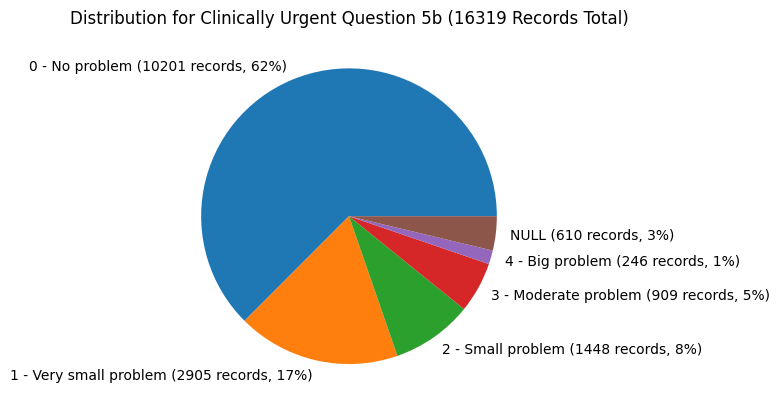

In [17]:
# Look at distribution of answers for question 4d (how big a problem is weak urine stream/incomplete emptying.....)
answer_options = ["0 - No problem", "1 - Very small problem", "2 - Small problem", "3 - Moderate problem", "4 - Big problem", "NULL"]
answer_dist = [10201, 2905, 1448, 909, 246, 610]
total_answers = sum(answer_dist)
plt.pie(answer_dist, labels = [f"{answer_options[i]} ({answer_dist[i]} records, {int(100*answer_dist[i]/total_answers)}%)" for i in range(len(answer_options))])
plt.title(f"Distribution for Clinically Urgent Question 5b ({total_answers} Records Total)")
plt.show()

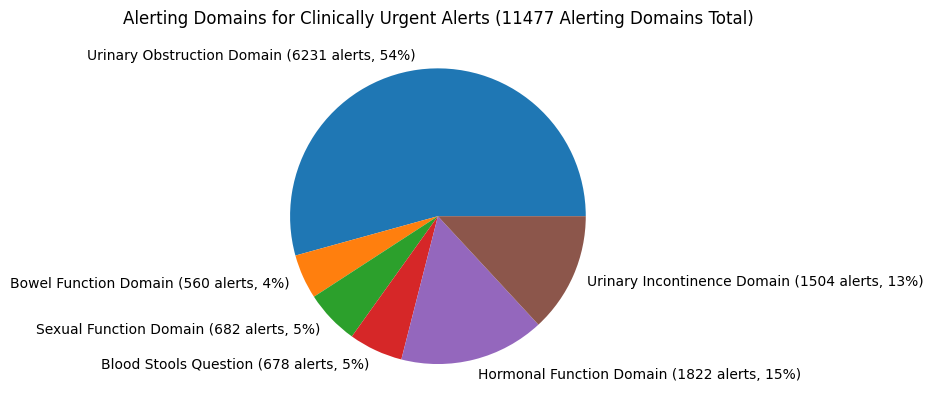

In [18]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()

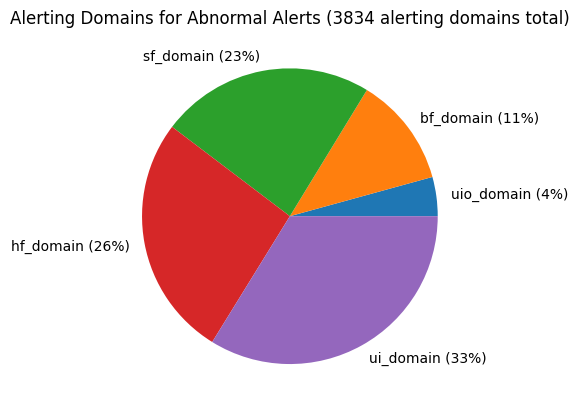

In [19]:
# Look at the frequency of which domains trigger an abnormal alert 

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Abnormal']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)/len(alert_domains)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{sub[0]} ({int(100*sub[1])}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Abnormal Alerts ({total_alerts} alerting domains total)")
plt.show()